In [1]:
import gym
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import yfinance as yf
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
class StockTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.df = df.reset_index()
        self.initial_balance = initial_balance

        # Actions: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = gym.spaces.Discrete(3)

        # Observation space: [current_price, balance, shares_held]
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(3,), dtype=np.float32)

        self.reset()

    def reset(self):
        self.balance = self.initial_balance
        self.shares_held = 0
        self.current_step = 0
        self.total_asset = self.balance
        return self._next_observation()

    def _next_observation(self):
        # Ensure that current_price is a scalar float
        current_price = float(self.df.loc[self.current_step, 'Close'].iloc[0])  # Using .iloc[0] to extract scalar value
        return np.array([current_price, self.balance, self.shares_held], dtype=np.float32)


    def step(self, action):
        current_price = float(self.df.loc[self.current_step, 'Close'].iloc[0])  # Using .iloc[0] to extract scalar value
        
        # Action handling (Buy, Sell, Hold)
        if action == 1:  # Buy
            shares_bought = self.balance // current_price
            self.balance -= shares_bought * current_price
            self.shares_held += shares_bought
        elif action == 2:  # Sell
            self.balance += self.shares_held * current_price
            self.shares_held = 0
        
        self.current_step += 1
        done = self.current_step >= len(self.df) - 1

        total_asset = self.balance + self.shares_held * current_price
        reward = total_asset - self.total_asset
        self.total_asset = total_asset

        return self._next_observation(), reward, done, {}

    def render(self):
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance:.2f}')
        print(f'Shares Held: {self.shares_held}')
        print(f'Total Asset: {self.total_asset:.2f}')


In [3]:

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(p=0.2)  # 20% dropout after first layer

        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(p=0.2)  # 20% dropout after second layer

        self.out = nn.Linear(32, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        return self.out(x)


In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, lr=1e-3,
                 batch_size=32, memory_size=10000, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.lr = lr
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size

        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = DQN(state_size, action_size).to(self.device)
        self.target_model = DQN(state_size, action_size).to(self.device)
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss_fn = nn.MSELoss()

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)

        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).to(self.device)
            next_state = torch.FloatTensor(next_state).to(self.device)

            # Compute the target value
            if done:
                target_val = reward
            else:
                with torch.no_grad():
                    target_val = reward + self.gamma * torch.max(self.target_model(next_state)).item()

            # Get current prediction
            output = self.model(state)[action]

            # Convert target_val to tensor with same shape as output
            target_tensor = torch.tensor(target_val, dtype=torch.float32, device=self.device)

            loss = self.loss_fn(output, target_tensor)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


        # Decay exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
# Download daily data for a stock (e.g., Apple)
df = yf.download('AAPL', start='2019-01-01', end='2023-01-01')
df = df[['Close']]  # We will use only the closing price
df = df.dropna()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
env = StockTradingEnv(df)
state = env.reset()  # Correctly call reset() to get the initial state

# Check the shape of the state to confirm it's as expected
print(f"Initial state: {state}, shape: {state.shape}")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize DQN agent
agent = DQNAgent(state_size, action_size)


Initial state: [   37.667187 10000.           0.      ], shape: (3,)


Episode 1/50, Total Reward: -442.20, Epsilon: 0.01
Episode 2/50, Total Reward: 1072.71, Epsilon: 0.01
Episode 3/50, Total Reward: 7002.98, Epsilon: 0.01
Episode 4/50, Total Reward: 904.52, Epsilon: 0.01
Episode 5/50, Total Reward: 22009.96, Epsilon: 0.01
Episode 6/50, Total Reward: 29016.54, Epsilon: 0.01
Episode 7/50, Total Reward: -2410.42, Epsilon: 0.01
Episode 8/50, Total Reward: 2157.51, Epsilon: 0.01
Episode 9/50, Total Reward: 24064.14, Epsilon: 0.01
Episode 10/50, Total Reward: 3518.57, Epsilon: 0.01
Episode 11/50, Total Reward: 13703.03, Epsilon: 0.01
Episode 12/50, Total Reward: 16129.18, Epsilon: 0.01
Episode 13/50, Total Reward: 10830.91, Epsilon: 0.01
Episode 14/50, Total Reward: 10766.62, Epsilon: 0.01
Episode 15/50, Total Reward: 34908.66, Epsilon: 0.01
Episode 16/50, Total Reward: 2069.53, Epsilon: 0.01
Episode 17/50, Total Reward: 5434.78, Epsilon: 0.01
Episode 18/50, Total Reward: 13065.34, Epsilon: 0.01
Episode 19/50, Total Reward: 3946.94, Epsilon: 0.01
Episode 20/5

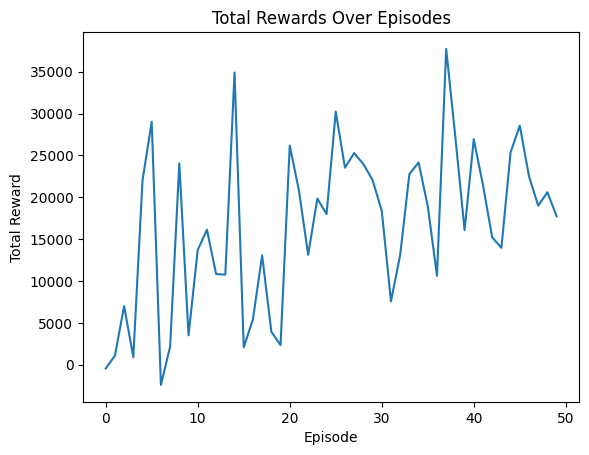

In [7]:
import matplotlib.pyplot as plt

episodes = 50  # Number of training episodes
total_rewards = []  # Track total rewards per episode

for e in range(episodes):
    state = env.reset()  # Reset environment for each episode
    total_reward = 0  # Reset reward for each episode

    while True:
        # Choose an action using epsilon-greedy policy
        action = agent.act(state)

        # Take the chosen action in the environment
        next_state, reward, done, _ = env.step(action)

        # Remember the experience
        agent.remember(state, action, reward, next_state, done)

        # Perform a step of the DQN replay (train)
        agent.replay()

        # Update the state
        state = next_state
        total_reward += reward

        if done:  # End of episode
            agent.update_target_model()  # Update target model after each episode
            total_rewards.append(total_reward)
            print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
            break

# Plot the total rewards over episodes to monitor training
plt.plot(total_rewards)
plt.title("Total Rewards Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.savefig("total_rewards_over_episodes.png", dpi=300)  # Save the plot as a PNG file
plt.show()


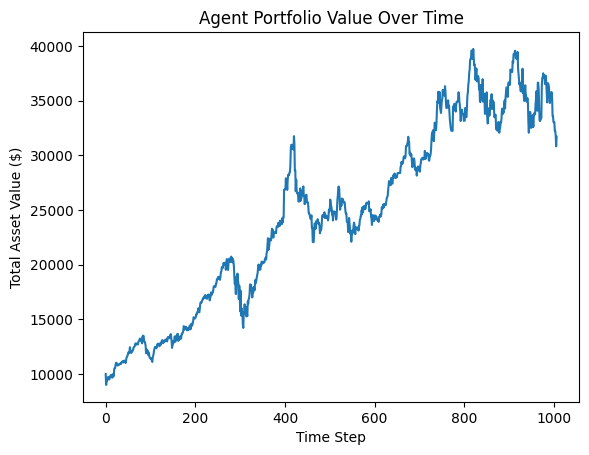

In [14]:
# After training, visualize the portfolio performance
state = env.reset()
asset_values = []

while True:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    asset_values.append(env.total_asset)  # Track the portfolio value over time
    state = next_state
    if done:
        break

# Plot the portfolio value over time
plt.plot(asset_values)
plt.title("Agent Portfolio Value Over Time")
plt.xlabel("Time Step")
plt.ylabel("Total Asset Value ($)")
plt.savefig("portfolio_value_over_time.png", dpi=300)  # Save the plot as a PNG file
plt.show()


In [9]:
# After training, save the model weights
torch.save(agent.model.state_dict(), "dqn_stock_model.pth")


In [10]:
# To load the saved model weights
agent.model.load_state_dict(torch.load("dqn_stock_model.pth"))


<All keys matched successfully>

In [12]:
plt.savefig("portfolio_value_over_time.png", dpi=300)  # Save the plot as a PNG file

<Figure size 640x480 with 0 Axes>